<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Pre-sets" data-toc-modified-id="Pre-sets-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Pre-sets</a></span></li></ul></li><li><span><a href="#Fitting-and-running-the-model-for-every-location-and-variant" data-toc-modified-id="Fitting-and-running-the-model-for-every-location-and-variant-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fitting and running the model for every location and variant</a></span></li><li><span><a href="#Loading-model-results" data-toc-modified-id="Loading-model-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Loading model results</a></span></li><li><span><a href="#Generating-figures" data-toc-modified-id="Generating-figures-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generating figures</a></span></li></ul></div>

# Process-based model

## Preamble

### Imports

In [1]:
import sys

In [2]:
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd
import plotnine as p9
from tqdm.auto import tqdm
from mizani.breaks import date_breaks
from mizani.formatters import custom_format
from src.process_based_model import run_model

### Pre-sets

In [4]:
p9.options.set_option('dpi', 150)
p9.theme_set(p9.theme_bw())

## Fitting and running the model for every location and variant

In [5]:
models = ['seasonal', 'constant', 'temperature']
regions = ['Barcelona', 'Catalunya', 'Lombardia', 'Thuringen']
region_periods = {'Barcelona': ['1', '2', '3'],
                  'Lombardia': ['1', '2'],
                  'Thuringen': ['1','2'],
                  'Catalunya':['1', '2', '3']}

models_map = {'constant': r'Constant $\beta$', 'temperature': r'$\beta(T)$',
              'seasonal': r'Seasonal $\beta$'}
periods_map = {'1': 'First Wave', '2': 'Second Wave', '3': 'Third Wave'}

In [19]:
for beta in tqdm(models, leave=False):
    for region in tqdm(regions, leave=False):
        for period in tqdm(region_periods[region], leave=False):
            params_path = f'../../data/process_based_model/parameters/{beta}/{region}{period}.pckl'
            res_df = run_model(beta_type='temperature',
                               location=region,
                               params_path=params_path,
                               n_iter=20,
                               seed=23)
            res_df.to_csv(f'../../results/tables/process_based_model/{region}_{period}_{beta}_.csv',
                         index=False)

## Loading model results

In [7]:
name_map = {'non_t_fit': 'constant', 'seasonal_fit': 'seasonal', 't_fit': 'temperature'}

In [8]:
source_folder = '../../results/tables/process_based_model/'
model_dfs = []
for model in models:
    for region in regions:
        for period in region_periods[region]:


            model_dfs.append(
                pd.read_csv(f'{source_folder}/{region}_{period}_{model}.csv')
                .assign(model=models_map[model], region=region, period=periods_map[period])
            )
            
model_dfs = (pd.concat(model_dfs)
             .reset_index(drop=True)
             .rename(columns={'Date': 'date'})
             .assign(date=lambda dd: pd.to_datetime(dd.date))
            )

In [9]:
real_data_df = []
for region in regions:
    real_data_df.append(
        pd.read_csv(f'../../data/process_based_model/training_data/{region}Data.csv')
        .assign(region=region)
    )
real_data_df = (pd.concat(real_data_df)
                .assign(date=lambda dd: pd.to_datetime(dd.Date))
                .drop(columns='Date')
               )

## Generating figures

In [10]:
full_df = model_dfs.merge(real_data_df, on=['date', 'region'])
full_df.columns = ['_'.join(c.lower().split(' ')) for c in full_df.columns]

In [11]:
 full_df = (full_df
 .melt(['date', 'period', 'region', 'model'])
 .loc[lambda dd: dd.variable.isin(['q', 'r', 'd', 'total_cases', 'std_q', 'std_r', 'std_d', 
                                   'std_total_cases', 'active', 'deaths',
                                   'recovered', 'confirmed'])]
 .assign(variable_type=lambda dd: dd.variable.apply(lambda x:
                                                   'std' if 'std' in x else 'mean'))
 .assign(variable=lambda dd: dd.variable.str.split('std_').str[-1])
 .pivot(['region', 'date', 'period', 'model', 'variable'], 'variable_type', 'value')
 .reset_index()
 .assign(prediction_type=lambda dd: dd.variable.apply(lambda x:
                                                'predicted' if x in ['q', 'd', 'r', 'total_cases']
                                                      else 'true'))
 .assign(variable=lambda dd: dd.variable.replace(
     {'q': 'active', 'd': 'deaths', 'r': 'recovered', 'total_cases': 'confirmed'}
 ))
  .rename(columns={'mean': 'value'})
           )

In [12]:
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'),
                         ['', 'k', 'M', 'B', 'T'][magnitude])

In [13]:
formatter = lambda x: [human_format(i) for i in x]

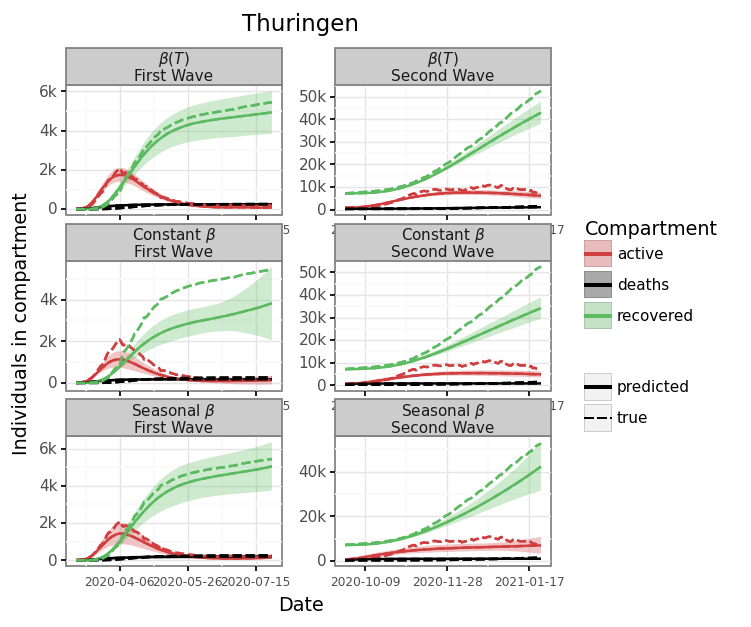

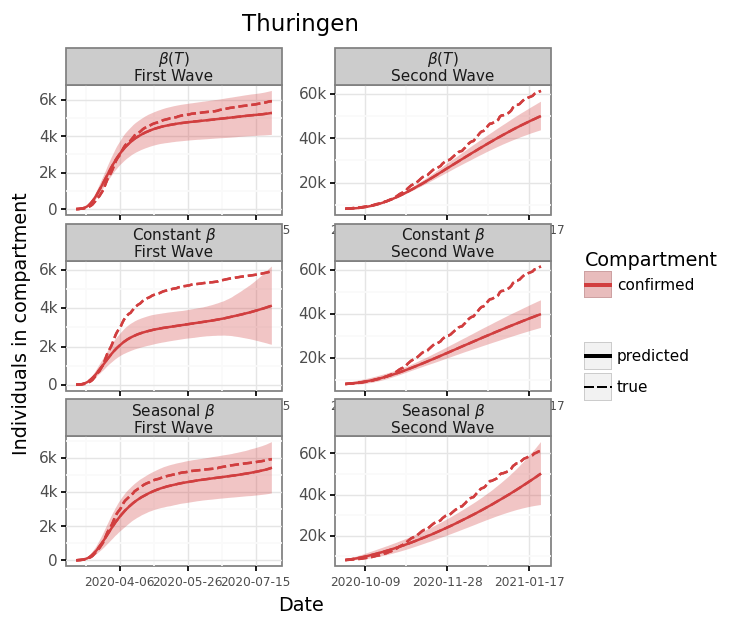

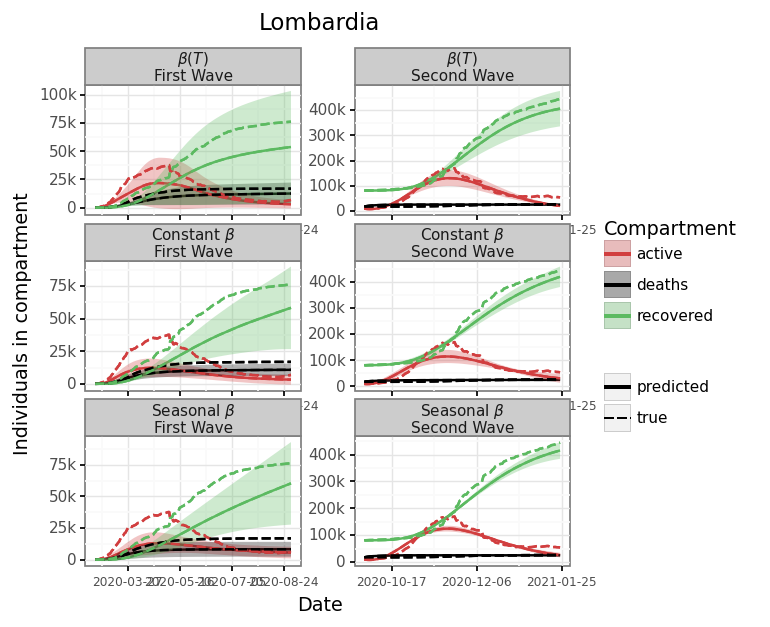

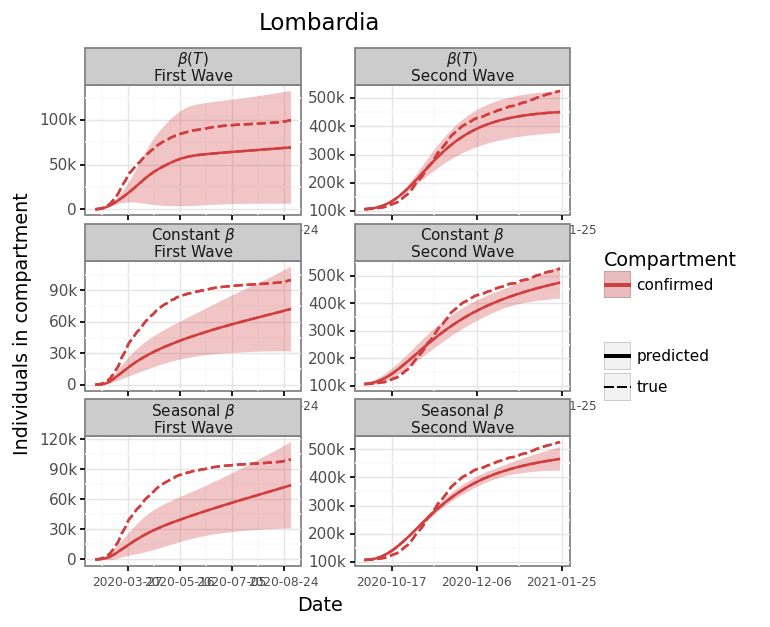

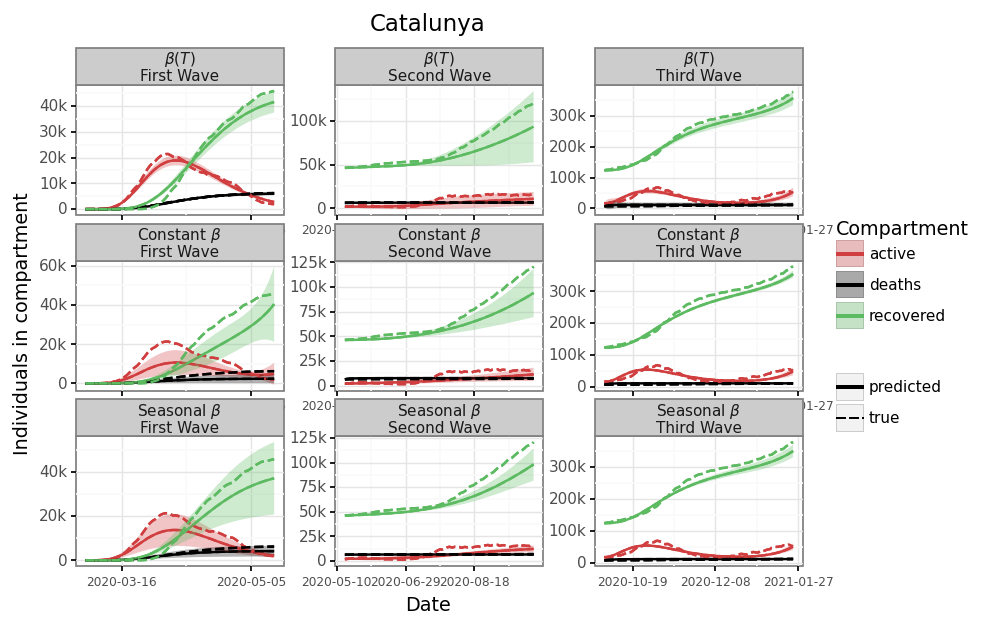

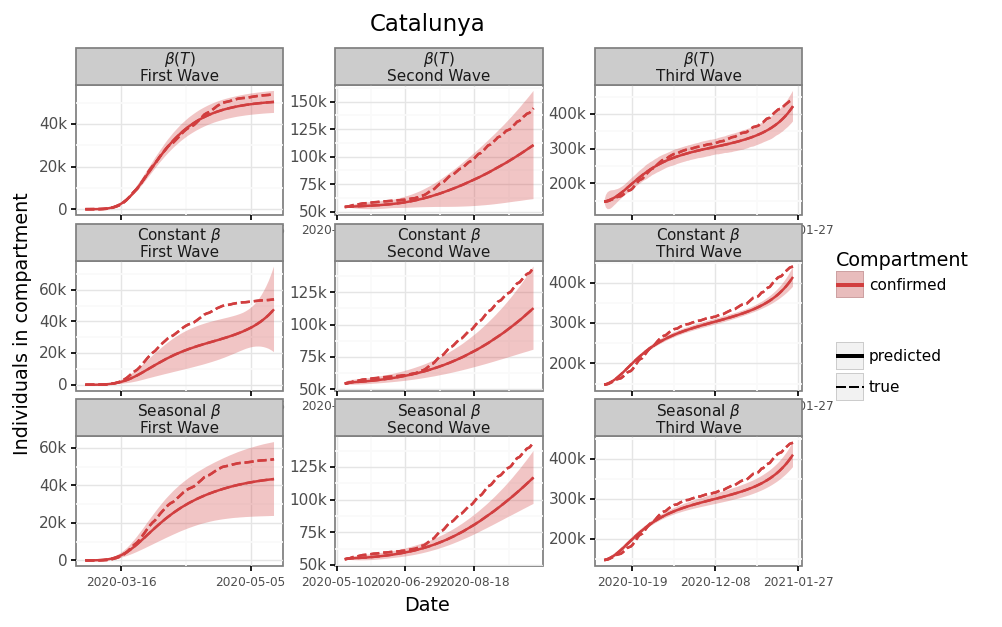

In [14]:
for region in ['Thuringen', 'Lombardia', 'Catalunya']:
    for i, variables in enumerate([['active', 'deaths', 'recovered'], ['confirmed']]):
        (full_df
          .loc[lambda dd: dd.region==region]
          .loc[lambda dd: dd.variable.isin(variables)]
          .pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('date', 'value', color='variable', group='variable + prediction_type',
                        fill='variable')
               + p9.geom_line(p9.aes(linetype='prediction_type'), size=.8)
               + p9.scale_fill_manual(['#D13E3F', 'black', '#5CBA61'])
               + p9.scale_color_manual(['#D13E3F', 'black', '#5CBA61'])
               + p9.geom_ribbon(p9.aes(ymin='value - std', ymax='value + std'), alpha=.3,
                                color=None, data=dd.loc[dd.prediction_type=='predicted'])
               + p9.geom_line(p9.aes(y='value'), linetype='dashed', size=.8)
               + p9.scale_x_datetime(breaks=date_breaks('50 days'))
               + p9.scale_y_continuous(labels=formatter)
               + p9.facet_wrap(['model', 'period'], scales='free', ncol=dd.period.nunique())
               + p9.theme(dpi=125, figure_size=(2.5 * dd.period.nunique(), 5),
                          subplots_adjust={'wspace':0.25, 'hspace': 0.35},
                          axis_text_x=p9.element_text(size=7))
               + p9.labs(x='Date', y='Individuals in compartment', title=region,
                         fill='Compartment', color='Compartment', linetype='')
               )
        ).draw().savefig(f'../../results/figures/process_based_model/{region}_model.pdf',
                         bbox_inches='tight')

In [15]:
populations = {'Barcelona': 2227000,
             'Catalunya': 7780479,
             'Lombardia': 10060574,
             'Thuringen': 2392000}

/home/isglobal.lan/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-kEskwFRP-py3.8/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 7 rows containing missing values.


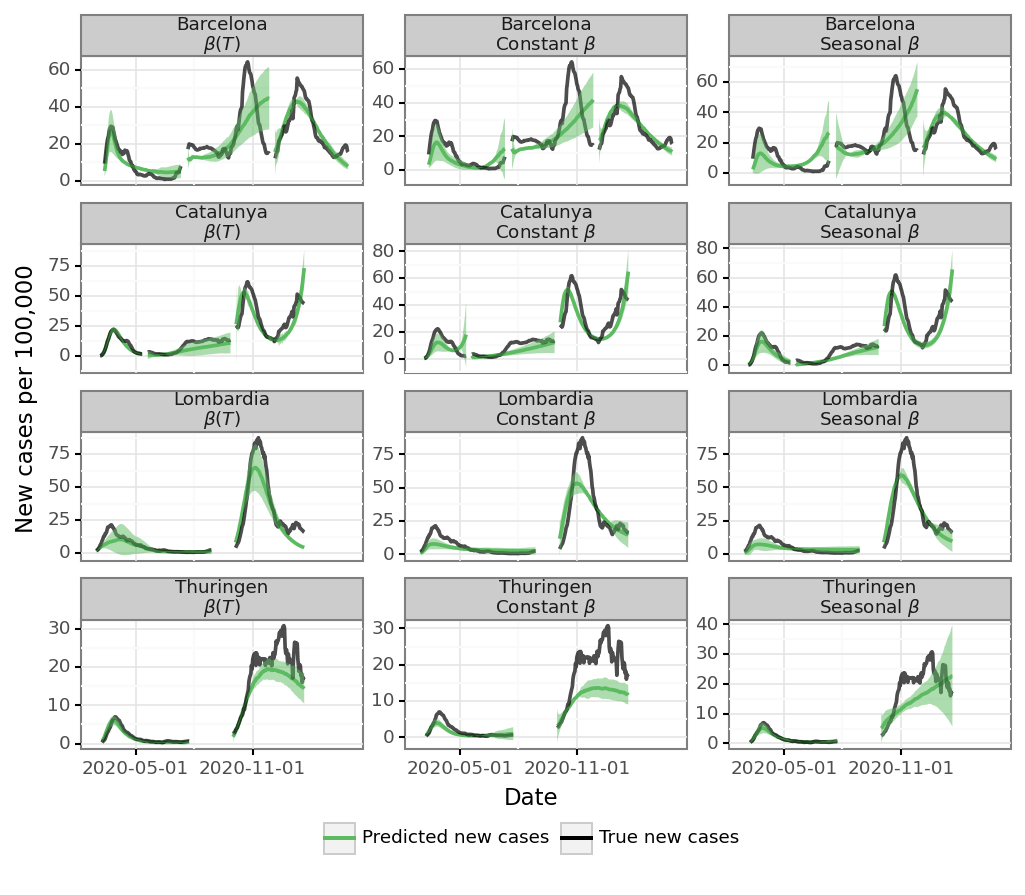

In [16]:
(full_df
 .loc[lambda dd: dd.variable=='confirmed']
 .groupby(['region', 'period', 'model', 'prediction_type'])
 .apply(lambda dd: dd.assign(new_cases=lambda dd: 
                dd.value.diff().rolling(window=7, center=True).mean() /
                             populations[dd.region.unique()[0]] * 100_000,
        new_cases_max=(dd.value + dd['std']).diff().rolling(window=7, center=True).mean() /
                             populations[dd.region.unique()[0]] * 100_000,
        new_cases_min=(dd.value - dd['std']).diff().rolling(window=7, center=True).mean() /
                             populations[dd.region.unique()[0]] * 100_000
                            )
       )
 .reset_index(drop=True)
 .replace({'predicted': 'Predicted new cases',
           'true': 'True new cases'})
  .pipe(lambda dd: p9.ggplot(dd) 
        + p9.aes('date', 'new_cases', group='period + prediction_type', color='prediction_type',
                 alpha='prediction_type') 
        + p9.geom_line(size=1)
        + p9.geom_ribbon(p9.aes(ymax='new_cases_max', ymin='new_cases_min'), alpha=.5,
                         fill='#5CBA61', color=None)
        + p9.scale_color_manual(['#5CBA61', 'black'])
        + p9.scale_alpha_manual([1, .7])
        + p9.facet_wrap(['region', 'model'], ncol=3, scales='free_y')
        + p9.theme(figure_size=(8, 6), dpi=150, subplots_adjust={'wspace': 0.15},
                   legend_position='bottom')
        + p9.scale_x_datetime(breaks=date_breaks('6 months'))
        + p9.labs(x='Date', y='New cases per 100,000', color='')
        + p9.guides(alpha=False)

       ).draw().savefig('../../results/figures/process_based_model/model_fits.pdf',
                        bbox_inches='tight')

)

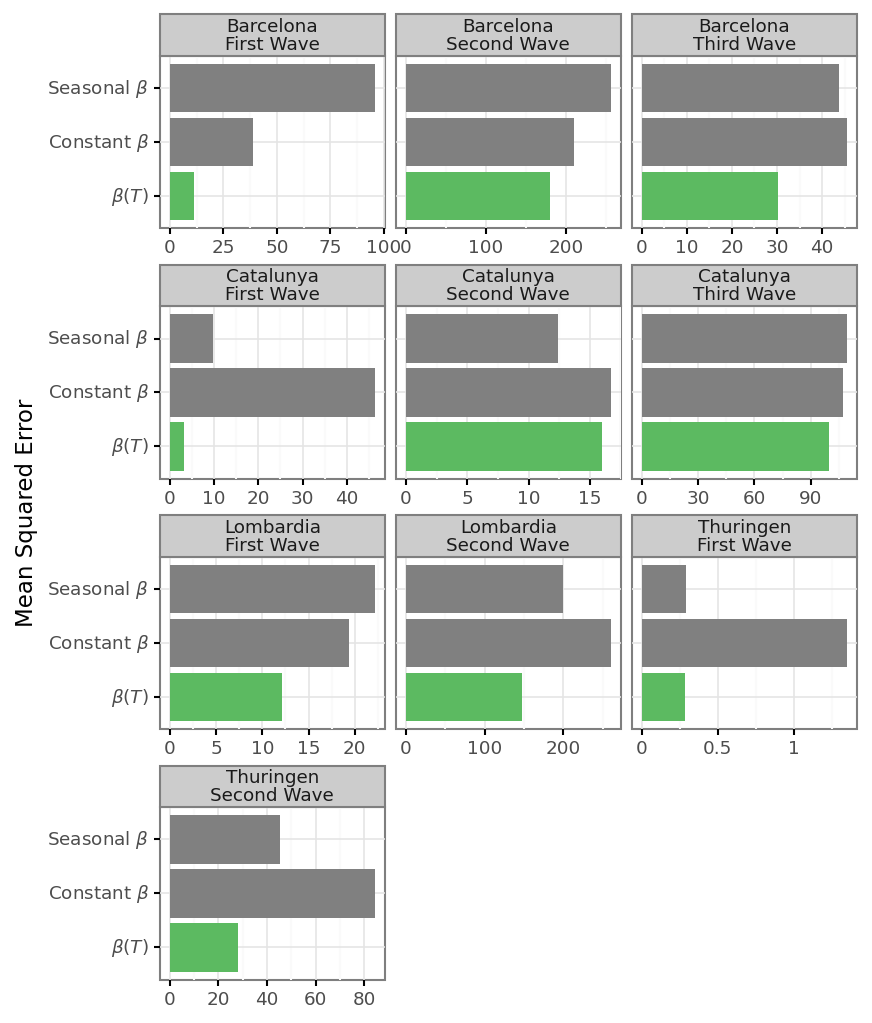

In [17]:
(full_df
 .loc[lambda dd: dd.variable=='confirmed']
 .groupby(['region', 'period', 'model', 'prediction_type'])
  .apply(lambda dd: dd.assign(new_cases=lambda dd: 
                 dd.value.diff().rolling(window=7, center=True).mean() 
                              / populations[dd.region.unique()[0]] * 100_000))
  .reset_index(drop=True)
  .loc[lambda dd: dd.new_cases.notna()]
  .pivot(['region', 'date', 'period', 'model', 'variable'], 'prediction_type', 'new_cases')
  .assign(residuals=lambda dd: (dd['predicted'] - dd['true']).pow(2))
  .reset_index()
  .groupby(['region', 'model', 'period'], as_index=False)
  .residuals.mean()
  .pipe(lambda dd: p9.ggplot(dd) 
        + p9.aes('model', 'residuals', fill='model')
        + p9.geom_col()
        + p9.facet_wrap(['region', 'period'], ncol=3, scales='free_x')
        + p9.scale_fill_manual(['#5CBA61', 'gray', 'gray'])
        + p9.coord_flip()
        + p9.theme(subplots_adjust={'hspace': 0.45}, figure_size=(6, 8))
        + p9.labs(x='Mean Squared Error', y='')
        + p9.guides(fill=False)
).draw().savefig('../../results/figures/process_based_model/model_residuals.pdf')
)
